# Set up a regional CESM-MOM6 run with CrocoDash

A typical workflow of utilizing CrocoDash consists of four main steps:

1. Generate a regional MOM6 domain.
2. Create the CESM case.
3. Prepare ocean forcing data.
4. Build and run the case.

# SECTION 1: Generate a regional MOM6 domain

We begin by defining a regional MOM6 domain using CrocoDash. To do so, we first generate a horizontal grid. We then generate the topography by remapping an existing bathymetric dataset to our horizontal grid. Finally, we define a vertical grid.

## Step 1.1: Horizontal Grid

In [1]:
from CrocoDash.grid import Grid

grid = Grid(
  resolution = 0.05,
  xstart = 192.0,
  lenx = 17.0,
  ystart = 16.0,
  leny = 11.0,
  name = "hawaii_1",
)

## Step 1.2: Topography

In [2]:
from CrocoDash.topo import Topo

topo = Topo(
    grid = grid,
    min_depth = 9.5,
)

In [3]:
bathymetry_path='/glade/work/altuntas/croc/input/GEBCO_2024_coarse_x4.nc'

topo.interpolate_from_file(
    file_path = bathymetry_path,
    longitude_coordinate_name="lon",
    latitude_coordinate_name="lat",
    vertical_coordinate_name="elevation"
)

Begin regridding bathymetry...

Original bathymetry size: 6.24 Mb
Regridded size: 1.80 Mb
Automatic regridding may fail if your domain is too big! If this process hangs or crashes,open a terminal with appropriate computational and resources try calling ESMF directly in the input directory None via

`mpirun -np NUMBER_OF_CPUS ESMF_Regrid -s bathymetry_original.nc -d bathymetry_unfinished.nc -m bilinear --src_var depth --dst_var depth --netcdf4 --src_regional --dst_regional`

For details see https://xesmf.readthedocs.io/en/latest/large_problems_on_HPC.html

Afterwards, run the 'expt.tidy_bathymetry' method to skip the expensive interpolation step, and finishing metadata, encoding and cleanup.



Regridding successful! Now calling `tidy_bathymetry` method for some finishing touches...
Tidy bathymetry: Reading in regridded bathymetry to fix up metadata...done. Filling in inland lakes and channels... done.
setup bathymetry has finished successfully.


**TODO:** when the above topo.interpolate_from_file() method is called with the original GEBCO dataset, the interpolation fails do to large computational demand when run on login nodes. Check if there is a failsafe way, or at least, a means to precaution the user.

**TODO:** Make required data available online (not just on glade).

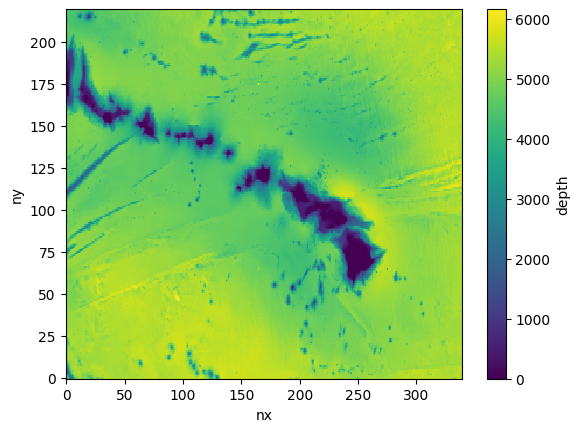

In [4]:
topo.depth.plot()

**TODO:** implement mask_disconnected_ocean_areas() in mom6_bathy, possibly via TopoEditor widget.

## Step 1.3: Vertical Grid

In [5]:
from CrocoDash.vgrid import VGrid

vgrid  = VGrid.hyperbolic(
    nk = 75,
    depth = topo.max_depth,
    ratio=20.0
)

In [6]:
print(vgrid.dz)

[  8.10187801   8.15305521   8.21365895   8.28541554   8.37036344
   8.47090806   8.58988555   8.73063677   8.8970927    9.09387247
   9.32639523   9.60100678   9.92512126  10.30737792  10.75781155
  11.28803353  11.91141861  12.6432888   13.50108226  14.5044892
  15.6755308   17.03854913  18.62006806  20.44847695  22.55348287
  24.96527506  27.71335118  30.82497199  34.32324434  38.2248831
  42.53777182  47.25852245  52.37031299  57.84133858  63.62422046
  69.65665823  75.86347435  82.16        88.45652565  94.66334177
 100.69577954 106.47866142 111.94968701 117.06147755 121.78222818
 126.0951169  129.99675566 133.49502801 136.60664882 139.35472494
 141.76651713 143.87152305 145.69993194 147.28145087 148.6444692
 149.8155108  150.81891774 151.6767112  152.40858139 153.03196647
 153.56218845 154.01262208 154.39487874 154.71899322 154.99360477
 155.22612753 155.4229073  155.58936323 155.73011445 155.84909194
 155.94963656 156.03458446 156.10634105 156.16694479 156.21812199]


# SECTION 2: Create the CESM case

After generating the MOM6 domain, the next step is to create a CESM case using CrocoDash. This process is straightforward and involves instantiating the CrocoDash Case object. The Case object requires the following inputs:

 - CESM Source Directory: A local path to a compatible CESM source copy.
 - Case Name: A unique name for the CESM case.
 - Input Directory: The directory where all necessary input files will be written.
 - MOM6 Domain Objects: The horizontal grid, topography, and vertical grid created in the previous section.
 - Project ID: (Optional) A project ID, if required by the machine.

## Step 2.1: Specify case name and directories:

Begin by specifying the case name and the necessary directory paths. Ensure the CESM root directory points to your own local copy of CESM. Below is an example setup:

In [7]:
from pathlib import Path

In [8]:
# CESM case (experiment) name
casename = "fresh-hawaii-t2"

# CESM source root (Update this path accordingly!!!)
cesmroot = Path.home() / "cesm3_0_beta04"

# Place where all your input files go 
inputdir = Path.home() / "croc_input" / casename
    
# CESM case directory
caseroot = Path.home() / "croc_cases" / casename

## Step 2.2: Create the Case

To create the CESM case, instantiate the `Case` object as shown below. This will automatically set up the CESM case based on the provided inputs: The `cesmroot` argument specifies the path to your local CESM source directory.
The `caseroot` argument defines the directory where the case will be created. CrocoDash will handle all necessary namelist modifications and XML changes to align with the MOM6 domain objects generated earlier.

In [9]:
from CrocoDash.case import Case

case = Case(
    cesmroot = cesmroot,
    caseroot = caseroot,
    inputdir = inputdir,
    ocn_grid = grid,
    ocn_vgrid = vgrid,
    ocn_topo = topo,
    project = 'NCGD0011',
    override = True,
)

INFO:  csp_solver:CspSolver initialized.


Creating case...

• Updating ccs_config/modelgrid_aliases_nuopc.xml file to include the new resolution "fresh-hawaii-t2" consisting of the following component grids.
 atm grid: "TL319", lnd grid: "TL319", ocn grid: "hawaii_1".

• Updating ccs_config/component_grids_nuopc.xml file to include newly generated ocean grid "hawaii_1" with the following properties:
 nx: 340, ny: 220. ocean mesh: /glade/u/home/altuntas/croc_input/fresh-hawaii-t2/ocnice/ESMF_mesh_hawaii_1_de9bf6.nc.

Running the create_newcase tool with the following command:

/glade/u/home/altuntas/cesm3_0_beta04/cime/scripts/create_newcase --compset 1850_DATM%JRA_SLND_SICE_MOM6_SROF_SGLC_SWAV --res fresh-hawaii-t2 --case /glade/u/home/altuntas/croc_cases/fresh-hawaii-t2 --machine derecho --run-unsupported --project NCGD0011 

The create_newcase command was successful.

Navigating to the case directory:

cd /glade/u/home/altuntas/croc_cases/fresh-hawaii-t2

Running the case.setup script with the following command:

./case.setu

INFO:	stage:SUCCESS: All stages are complete.


Case created successfully at /glade/u/home/altuntas/croc_cases/fresh-hawaii-t2.

To further customize, build, and run the case, navigate to the case directory in your terminal. To create another case, restart the notebook.



# Section 3: Prepare ocean forcing data

We need to cut out our ocean forcing. The package expects an initial condition and one time-dependent segment per non-land boundary. Naming convention is `"east_unprocessed"` for segments and `"ic_unprocessed"` for the initial condition.

In this notebook, we are forcing with the Copernicus Marine "Glorys" reanalysis dataset. There's a function in the `CrocoDash` package, called `configure_forcings`, that generates a bash script to download the correct boundary forcing files for your experiment. First, you will need to create an account with Copernicus, and then call `copernicusmarine login` to set up your login details on your machine. Then you can run the `get_glorys_data.sh` bash script.

## Step 3.1 Configure Initial Conditions and Forcings


In [10]:
case.configure_forcings(
    date_range = ["2020-01-01 00:00:00", "2020-02-01 00:00:00"],
    tidal_constituents = ['M2'],
    tpxo_elevation_filepath = "/glade/u/home/manishrv/manish_scratch_symlink/inputs_rm6/tidal_data/h_tpxo9.v1.nc",
    tpxo_velocity_filepath = "/glade/u/home/manishrv/manish_scratch_symlink/inputs_rm6/tidal_data/u_tpxo9.v1.nc"
)

This means that some areas may only have one or two layers between the surface and sea floor. 
For increased stability, consider increasing the minimum depth, or adjusting the vertical coordinate to add more layers near the surface.
The script `get_glorys_data.sh` has been generated at:
  /glade/u/home/altuntas/croc_input/fresh-hawaii-t2/glorys.
To download the data, run this script using `bash` in a terminal with internet access.

Important instructions:
1. You will need your Copernicus Marine username and password.
   If you do not have an account, you can create one here: 
   https://data.marine.copernicus.eu/register
2. You will be prompted to enter your Copernicus Marine credentials multiple times: once for each dataset.
3. Depending on the dataset size, the download process may take significant time and resources.
4. Thus, on certain systems, you may need to run this script as a batch job.



## Step 3.2 Run `get_glorys_data.sh`

In a terminal session, locate the `get_glorys_data.sh` script and execute it to download the initial conditions and boundary conditions. Follow the instructions printed by the `configure_forcings` method above.


**TODO:** user copernicusmarine python API within CrocoDash, instead of directing users to run it via CLI. Also, on a derecho login node, both CLI and API fails to run due to the computational demand. We also need to address that.

##  Step 3.3: Process forcing data

In this final step, we call the `process_forcings` method of CrocoDash to cut out and interpolate the initial condition as well as all boundaries. CrocoDash also updates MOM6 runtime parameters and CESM xml variables accordingly.

In [11]:
case.process_forcings()

INITIAL CONDITIONS
Regridding Velocities... Done.
Regridding Tracers... Done.
Regridding Free surface... Done.
Saving outputs... done setting up initial condition.
[########################################] | 100% Completed | 102.34 ms
Done.
[########################################] | 100% Completed | 121.53 ms
Done.
[########################################] | 100% Completed | 102.80 ms
Done.
[########################################] | 100% Completed | 102.35 ms
Done.
Processing south boundary...Done
Processing north boundary...Done
Processing west boundary...Done
Processing east boundary...Done
Adding parameter changes to user_nl_mom:

  ! Initial conditions
  INIT_LAYERS_FROM_Z_FILE = True
  TEMP_SALT_Z_INIT_FILE = init_tracers.nc
  Z_INIT_FILE_PTEMP_VAR = temp
  Z_INIT_ALE_REMAPPING = True
  TEMP_SALT_INIT_VERTICAL_REMAP_ONLY = True
  DEPRESS_INITIAL_SURFACE = True
  SURFACE_HEIGHT_IC_FILE = init_eta.nc
  SURFACE_HEIGHT_IC_VAR = eta_t
  VELOCITY_CONFIG = file
  VELOCITY_FILE = in

# Section 4: Build and run the case

After completing the previous steps, you are ready to build and run your CESM case. Begin by navigating to the case root directory specified during the case creation. Before proceeding, review the `user_nl_mom` file located in the case directory. This file contains MOM6 parameter settings that were automatically generated by CrocoDash. Carefully examine these parameters and make any necessary adjustments to fine-tune the model for your specific requirements. While CrocoDash aims to provide a solid starting point, further tuning and adjustments are typically necessary to improve the model for your use case.

Once you have reviewed and modified the parameters as needed, you can build and execute the case using the following commands: 
```
./case.build
./case.submit
```